# 猫狗大战（Dogs vs Cats）


## 项目介绍

使用要迁移学习的模型，使用提取的bottleneck特征来训练新模型。

<a id="step0"></a>
## 1. 导入数据集

读取datas目录下的数据集，并分为train和test两类。

In [1]:
import os
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

data = load_files('datas')

files = np.array(data['filenames'])
targets = np.array(data['target'])
target_names = np.array(data['target_names'])

test_files = [files[idx] for idx in range(len(files)) if targets[idx] == np.argwhere(target_names == 'test')]

def getFileName(elem):
    _,file = os.path.split(elem)
    name,_ = os.path.splitext(file)
    return int(name)
test_files.sort(key=getFileName)

print("There are {} test images.".format(len(test_files)))

Using TensorFlow backend.


There are 12500 test images.


<a id="step2"></a>
## 2. 模型预测


### 2.1 构建模型

为了提高模型的训练速度和质量，这里使用迁移学习，主要构建全连接层模型。

In [2]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(1, 1, 2048)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 2,049.0
Trainable params: 2,049.0
Non-trainable params: 0.0
_________________________________________________________________


## 2.2 训练模型

使用构建好的模型进行训练，并将训练的权重保存到hdf5文件中。

In [3]:
# 加载已生成的bottleneck features
bottleneck_features = np.load('bottlenecks_resnet50.npz')
X_train = bottleneck_features['X_train']
y_train = bottleneck_features['y_train']
X_valid = bottleneck_features['X_valid']
y_valid = bottleneck_features['y_valid']
X_test = bottleneck_features['X_test']
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(20000, 1, 1, 2048)
(20000,)
(5000, 1, 1, 2048)
(5000,)
(12500, 1, 1, 2048)


In [4]:
from keras.callbacks import ModelCheckpoint

# 训练全连接层网络模型
checkpointer = ModelCheckpoint(filepath='weights_best_resnet50.hdf5', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
        epochs=20, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 2s - loss: 0.0818 - acc: 0.9697 - val_loss: 0.0366 - val_acc: 0.9874
Epoch 2/20
20000/20000 [==============================] - 2s - loss: 0.0496 - acc: 0.9819 - val_loss: 0.0324 - val_acc: 0.9872
Epoch 3/20
20000/20000 [==============================] - 2s - loss: 0.0394 - acc: 0.9856 - val_loss: 0.0295 - val_acc: 0.9898
Epoch 4/20
20000/20000 [==============================] - 2s - loss: 0.0408 - acc: 0.9847 - val_loss: 0.0324 - val_acc: 0.9882
Epoch 5/20
20000/20000 [==============================] - 2s - loss: 0.0391 - acc: 0.9864 - val_loss: 0.0308 - val_acc: 0.9890
Epoch 6/20
20000/20000 [==============================] - 2s - loss: 0.0383 - acc: 0.9877 - val_loss: 0.0320 - val_acc: 0.9880
Epoch 7/20
20000/20000 [==============================] - 2s - loss: 0.0366 - acc: 0.9872 - val_loss: 0.0326 - val_acc: 0.9884
Epoch 8/20
20000/20000 [==============================] - 2s -

将模型的训练过程进行可视化。

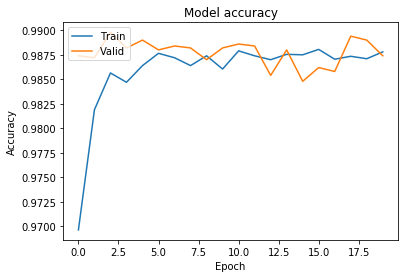

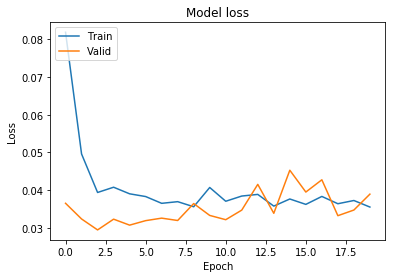

In [5]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

## 2.3 验证模型

根据测试集中的数据进行预测。

In [9]:
# Load trained model weights
model.load_weights('weights_best_resnet50.hdf5')

# Predict test set
y_test = [model.predict(np.expand_dims(feature, axis=0)) for feature in X_test]
test_pred = [0 if y[0][0] < 0.5 else 1 for y in y_test]
test_result = [min(max(y[0][0],0.005),0.995) for y in y_test]
print(y_test[0:5])
print(test_pred[0:5])
print(test_result[0:5])

[array([[ 0.99996257]], dtype=float32), array([[ 0.99999869]], dtype=float32), array([[ 0.99999142]], dtype=float32), array([[ 0.99847955]], dtype=float32), array([[  8.73829140e-06]], dtype=float32)]
[1, 1, 1, 1, 0]
[0.99996257, 0.99999869, 0.99999142, 0.99847955, 8.7382914e-06]


将部分预测的结果进行可视化预览

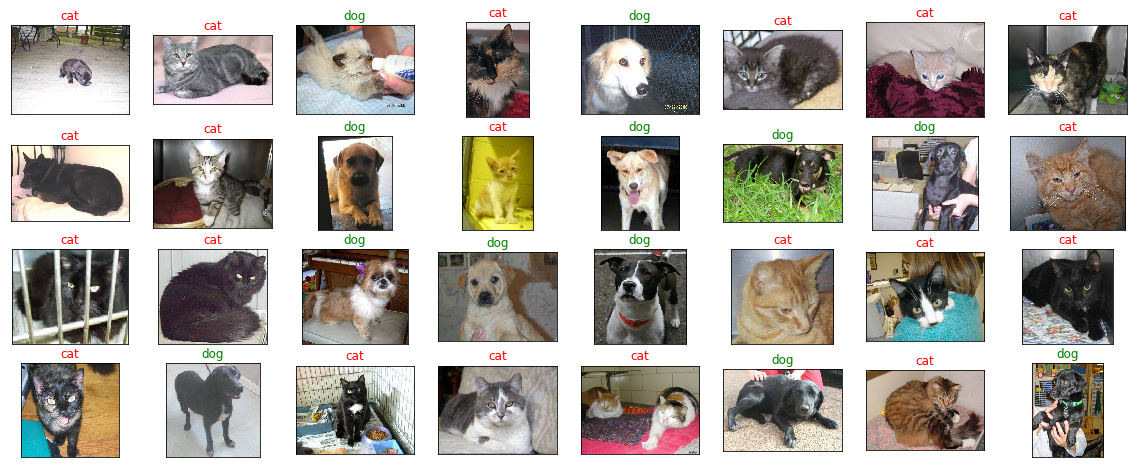

In [10]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# plot a random sample of test images, their predicted labels
data_labels = ("cat", "dog")
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    visualize_img(test_files[idx], ax)
    pred_idx = test_pred[idx]
    ax.set_title("{}".format(data_labels[pred_idx]), color=("green") if pred_idx > 0 else ("red"))

将预测的结果提交到kaggle，以便得到模型的准确率排名。

In [13]:
import pandas as pd

## 加载结果格式
submit_frame = pd.read_csv("sample_submission.csv")
## 保存结果
submit_frame['label'] = test_result
result_name = "submission.csv"
submit_frame[['id','label']].to_csv(result_name,index=False)